## Data loading

### Mesh loading & reorientation

In [1]:
from mesh4d import obj3d

mesh_ls, _ = obj3d.load_mesh_series(
    folder='/Users/knpob/Territory/Kolmo/data/DynaFootLite/Fast',
    start=0,
    stride=1,
    end=4,
    load_texture=False,
)

[====================] 100.0% loading: /Users/knpob/Territory/Kolmo/data/DynaFootLite/Fast/Sub05_Fast_L1_102_143.000031.obj


In [2]:
# helper functions
def coord_cartesian2homo(vertices):
    shape = list(vertices.shape)
    shape[1] += 1

    vertices_homo = np.ones(shape)
    vertices_homo[:, :3] = vertices
    return vertices_homo

def coord_homo2cartesian(vertices_homo):
    return vertices_homo[:, :3] / vertices_homo[:, [-1]]

def transformation_matrix2global(axes, origin):
    """e(i) -> a_i + t"""
    matrix = np.eye(4)
    matrix[:3, :3] = axes.T
    matrix[:3, 3] = origin
    
    return matrix

def transformation_matrix2local(axes, origin):
    """a_i + t -> e(i)"""
    matrix2golbal = transformation_matrix2global(axes, origin)
    return np.linalg.inv(matrix2golbal)

def transform(matrix, vertices):
    vertices_homo = coord_cartesian2homo(vertices)
    vertices_transform = (matrix @ vertices_homo.T).T
    return coord_homo2cartesian(vertices_transform)

In [4]:
import numpy as np
from mesh4d import utils

axes_ls = utils.load_pkl_object('output/axes/fast_axes.pkl')

mesh_transform_ls = []

for idx in range(len(mesh_ls)):
    matrix = transformation_matrix2local(axes_ls[idx]['axes'], axes_ls[idx]['mean'])
    mesh_transform_ls.append(mesh_ls[idx].transform(matrix, inplace=False))

### Add ground points to landmarks

In [5]:
landmarks = utils.load_pkl_object('output/transform/fast_transform.pkl')
landmarks.to_array()[0].shape

(5, 12, 3)

In [6]:
ground_ls = []

for frame in range(len(mesh_transform_ls)):
    min_idx = mesh_transform_ls[frame].points[:, -1].argmin()
    ground = mesh_transform_ls[frame].points[min_idx]
    ground_ls.append(ground)

ground_array = np.array(ground_ls)
ground_array

array([[-224.9362   ,  -94.49914  , -147.99239  ],
       [-228.71582  , -142.8754   ,  -98.01931  ],
       [-230.79794  , -141.10628  ,  -78.01176  ],
       [-229.56525  , -145.3405   ,  -67.79389  ],
       [ 129.44643  ,   -4.3073916, -123.388115 ]], dtype=float32)

In [7]:
from mesh4d.kps import MarkerSet

array, names = landmarks.to_array()
landmarks.load_from_array(
    array=np.concatenate([array, np.expand_dims(ground_array, axis=-2)], axis=-2),
    index=names + ['Ground'],
    )

## Euclidean measurements

> Zhang, L. Y., Yick, K. L., Yue, M. J., Yip, J., & Ng, S. P. (2023). An exploratory study of dynamic foot shape measurements with 4D scanning system. Scientific Reports, 13(1), 8628.

In [8]:
# helper functions
def get(landmarks, marker_name, axis):
    axis2idx = {
        'x': 0,
        'y': 1,
        'z': 2
    }
    return landmarks.markers[marker_name].coord[axis2idx[axis]]

def dist_along_axis(landmarks, marker1, marker2, axis, is_abs=True):
    dist = landmarks.get(marker1, axis) - landmarks.get(marker2, axis)

    if is_abs:
        return np.abs(dist)
    else:
        return dist

def dist(landmarks, marker1, marker2):
    return np.linalg.norm(landmarks.markers[marker1].coord - landmarks.markers[marker2].coord, axis=0)

def angle(landmarks, marker_origin, marker1, marker2):
    v1 = (landmarks.markers[marker1].coord - landmarks.markers[marker_origin].coord).T
    v2 = (landmarks.markers[marker2].coord - landmarks.markers[marker_origin].coord).T
    cos = np.abs(np.sum(v1 * v2, axis=-1)) / np.linalg.norm(v1, axis=-1) / np.linalg.norm(v2, axis=-1)
    return np.arccos(cos) / np.pi * 180

type(landmarks).get = get
type(landmarks).dist_along_axis = dist_along_axis
type(landmarks).dist = dist
type(landmarks).angle = angle

In [20]:
metric = {}

metric['FL'] = ['foot length (mm)']\
    + list(landmarks.dist_along_axis('P1', 'P10', 'x'))
metric['MBL'] = ['medial ball length (mm)']\
    + list(landmarks.dist_along_axis('P4', 'P10', 'x'))
metric['LBL'] = ['lateral ball length (mm)']\
    + list(landmarks.dist_along_axis('P5', 'P10', 'x'))
metric['ABW'] = ['anatomical ball width (mm)']\
    + list(landmarks.dist('P4', 'P5'))
metric['OBW'] = ['orthogonal ball width (mm)']\
    + list(landmarks.dist_along_axis('P4', 'P3', 'y'))
metric['OHW'] = ['orthogonal heel width (mm)']\
    + list(landmarks.dist_along_axis('P9', 'P8', 'y'))
metric['BH'] = ['ball heigh (mm)']\
    + list(landmarks.dist_along_axis('P6', 'Ground', 'z'))
metric['IH'] = ['instep height (mm)']\
    + list(landmarks.dist_along_axis('P7', 'Ground', 'z'))
metric['BA'] = ['ball angle (°)']\
    + list(landmarks.angle('P4', 'P5', 'P8'))
metric['T1A'] = ['toe 1 angle (°)']\
    + list(180 - landmarks.angle('P4', 'P2', 'P8'))
metric['T5A'] = ['toe 5 angle (°)']\
    + list(180 -landmarks.angle('P5', 'P3', 'P9'))

In [21]:
import pandas as pd

df = pd.DataFrame(metric, index=['description'] + [f'frame{idx}' for idx in range(len(landmarks.to_array()[0]))])
df

,FL,MBL,LBL,ABW,OBW,OHW,BH,IH,BA,T1A,T5A
description,foot length (mm),medial ball length (mm),lateral ball length (mm),anatomical ball width (mm),orthogonal ball width (mm),orthogonal heel width (mm),ball heigh (mm),instep height (mm),ball angle (°),toe 1 angle (°),toe 5 angle (°)
frame0,228.929442,178.560646,147.469258,88.830776,84.793977,61.817895,181.182802,194.384322,66.26804,165.455793,158.918937
frame1,230.429632,179.662188,157.309931,90.728457,92.961361,60.53912,134.854684,151.560502,71.75427,163.050042,173.647398
frame2,233.210296,180.575976,150.312609,94.605167,93.461096,61.408464,111.8199,125.310427,68.52086,165.931926,177.084967
frame3,234.539181,180.787102,152.578999,94.922436,91.539196,56.851708,100.308414,111.53635,68.70604,169.38002,171.411398
frame4,229.204787,174.767692,139.38236,93.4495,86.977474,55.608276,151.318786,164.236403,64.495468,168.259939,162.257729


### Visualization

<Axes: >

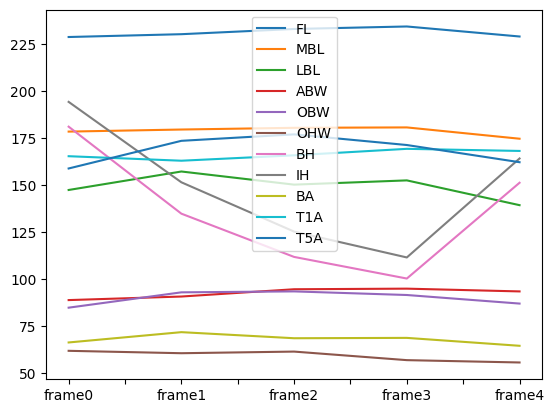

In [22]:
df['frame0':'frame4'].plot()

In [47]:
import pyvista as pv

# helper function
def plot_markers(scene, landmarks, marker_ls, frame_id=0, plot_label=False, **kwargs):
    points = np.array([landmarks.markers[marker].coord[:, frame_id] for marker in marker_ls])
    scene.add_points(points, render_points_as_spheres=True, point_size=10, **kwargs)

    if plot_label:
        scene.add_point_labels(points, marker_ls, font_size=20)

    return points

def plot_dist_along_axis(scene, landmarks, marker1, marker2, axis, frame_id=0, name='dist', **kwargs):
    marker_points = plot_markers(scene, landmarks, [marker1, marker2], frame_id, **kwargs)

    # plot axis frame
    dx = dist_along_axis(landmarks, marker1, marker2, 'x', is_abs=False)[frame_id]
    dy = dist_along_axis(landmarks, marker1, marker2, 'y', is_abs=False)[frame_id]
    dz = dist_along_axis(landmarks, marker1, marker2, 'z', is_abs=False)[frame_id]

    points = np.vstack([
        marker_points[1],
        marker_points[1] + np.array([dx, 0, 0]),
        marker_points[1] + np.array([dx, dy, 0]),
        marker_points[0],
        ])
    pdata = pv.PolyData(points)
    pdata.lines = np.hstack([[2, 0, 1], [2, 1, 2], [2, 2, 3]])
    scene.add_mesh(pdata, line_width=2, **kwargs)

    # plot axis dist
    if axis == 'x':
        points = np.vstack([
            marker_points[1],
            marker_points[1] + np.array([dx, 0, 0]),
            ])
        scene.add_point_labels([marker_points[1] + np.array([dx/2, 0, 0]),], [name,])
    
    elif axis == 'y':
        points = np.vstack([
            marker_points[1] + np.array([dx, 0, 0]),
            marker_points[1] + np.array([dx, dy, 0]),
            ])
        scene.add_point_labels([marker_points[1] + np.array([dx, dy/2, 0]),], [name,])
        
    elif axis=='z':
        points = np.vstack([
            marker_points[1] + np.array([dx, dy, 0]),
            marker_points[0],
            ])
        scene.add_point_labels([marker_points[1] + np.array([dx, dy, dz/2]),], [name,])
        
    pdata = pv.PolyData(points)
    pdata.lines = np.hstack([[2, 0, 1]])
    scene.add_mesh(pdata, line_width=5, **kwargs)

def plot_dist(scene, landmarks, marker1, marker2, frame_id=0, name='dist', **kwargs):
    points = plot_markers(scene, landmarks, [marker1, marker2], frame_id, **kwargs)
    lines = np.hstack([[2, 0, 1]])
    pdata = pv.PolyData(points)
    pdata.lines = lines
    scene.add_mesh(pdata, line_width=5, **kwargs)
    scene.add_point_labels([points.mean(axis=0),], [name,])

def plot_angle(scene, landmarks, marker_origin, marker1, marker2, frame_id=0, name='angle', **kwargs):
    points = plot_markers(scene, landmarks, [marker_origin, marker1, marker2], frame_id, **kwargs)
    pdata = pv.PolyData(points)
    pdata.lines = np.hstack([[2, 0, 1], [2, 0, 2]])
    scene.add_mesh(pdata, line_width=3, **kwargs)
    scene.add_point_labels(points.mean(axis=0), [name,])

In [24]:
frame_id = 0

axis_dist_dict = {
    'FL': ['P1', 'P10', 'x'],
    'MBL': ['P4', 'P10', 'x'],
    'LBL': ['P5', 'P10', 'x'],
    'OBW': ['P4', 'P3', 'y'],
    'OHW': ['P9', 'P8', 'y'],
    'BH': ['P6', 'Ground', 'z'],
    'IH': ['P7', 'Ground', 'z'],
}

for name, [marker1, marker2, axis] in axis_dist_dict.items():
    scene = pv.Plotter()
    scene.add_mesh(mesh_transform_ls[frame_id], color='white', opacity=0.5)
    plot_dist_along_axis(scene, landmarks, marker1, marker2, axis, frame_id, name=name, color='green')
    scene.screenshot(f'output/measure/{name}.png')

In [25]:
frame_id = 0

dist_dict = {
    'ABW': ['P4', 'P5'],
}

for name, [marker1, marker2] in dist_dict.items():
    scene = pv.Plotter()
    scene.add_mesh(mesh_transform_ls[frame_id], color='white', opacity=0.5)
    plot_dist(scene, landmarks, marker1, marker2, frame_id, name=name, color='green')
    scene.screenshot(f'output/measure/{name}.png')

In [ ]:
frame_id = 0

angle_dict = {
    'BA': ['P4', 'P5', 'P8'],
    'T1A': ['P4', 'P2', 'P8'],
    'T5A': ['P5', 'P3', 'P9'],
}

for name, [marker_origin, marker1, marker2] in angle_dict.items():
    scene = pv.Plotter()
    scene.add_mesh(mesh_transform_ls[frame_id], color='white', opacity=0.5)
    plot_angle(scene, landmarks, marker_origin, marker1, marker2, frame_id, name=name, color='green')
    scene.screenshot(f'output/measure/{name}.png')

## Manifold measurements

### Remove disconnected parts

In [26]:
mesh_fix_ls = []

for mesh in mesh_transform_ls:
    clean = mesh.clean()
    bodies = clean.split_bodies()

    point_nums = [len(body.points) for body in bodies]
    max_index = point_nums.index(max(point_nums))
    mesh_fix_ls.append(bodies[max_index].extract_surface())

In [27]:
# plot example
scene = pv.Plotter()
color_ls = ['r', 'g', 'b', 'y', 'm', 'c']

for idx, body in enumerate(bodies):
    scene.add_mesh(body.extract_surface(), opacity=0.5, color=color_ls[idx])

scene.show()

Widget(value="<iframe src='http://localhost:54025/index.html?ui=P_0x7fe781ad3ee0_18&reconnect=auto' style='wid…

### Circumference calculation

In [28]:
from mesh4d.analyse import measure

cir_ls = []

for frame in range(len(mesh_fix_ls)):
    p4 = landmarks.markers['P4'].coord[:, frame]
    p5 = landmarks.markers['P5'].coord[:, frame]
    id4 = mesh_fix_ls[frame].find_closest_point(p4)
    id5 = mesh_fix_ls[frame].find_closest_point(p5)

    # extract geodesic path
    path = mesh_fix_ls[frame].geodesic(id4, id5)

    # estimate circumference plane
    norm, center = measure.estimate_plane_from_points(path.points)
    mesh_clip = mesh_fix_ls[frame].clip(norm, origin=center, invert=True)

    # calculate circumference
    boundary = mesh_clip.extract_feature_edges(boundary_edges=True, feature_edges=False, manifold_edges=False)
    cir_ls.append(boundary.length)

In [29]:
df['ABG'] = ['anatomical ball girth'] + cir_ls
df

,FL,MBL,LBL,ABW,OBW,OHW,BH,IH,BA,T1A,T5A,ABG
description,foot length (mm),medial ball length (mm),lateral ball length (mm),anatomical ball width (mm),orthogonal ball width (mm),orthogonal heel width (mm),ball heigh (mm),instep height (mm),ball angle (°),toe 1 angle (°),toe 5 angle (°),anatomical ball girth
frame0,228.929442,178.560646,147.469258,88.830776,84.793977,61.817895,181.182802,194.384322,66.26804,165.455793,158.918937,132.788938
frame1,230.429632,179.662188,157.309931,90.728457,92.961361,60.53912,134.854684,151.560502,71.75427,163.050042,173.647398,126.761068
frame2,233.210296,180.575976,150.312609,94.605167,93.461096,61.408464,111.8199,125.310427,68.52086,165.931926,177.084967,350.22798
frame3,234.539181,180.787102,152.578999,94.922436,91.539196,56.851708,100.308414,111.53635,68.70604,169.38002,171.411398,130.161966
frame4,229.204787,174.767692,139.38236,93.4495,86.977474,55.608276,151.318786,164.236403,64.495468,168.259939,162.257729,122.91516


### Visualization

In [37]:
scene = pv.Plotter()
scene.add_mesh(mesh_fix_ls[frame], opacity=0.5, color='white')
plot_markers(scene, landmarks, ['P4', 'P5'], frame, plot_label=True)
scene.add_mesh(mesh_clip, opacity=0.5, color='r')
scene.add_mesh(boundary, color='black')
scene.screenshot('output/measure/ABG.png')
scene.show()

Widget(value="<iframe src='http://localhost:54025/index.html?ui=P_0x7fe7b3eb06d0_26&reconnect=auto' style='wid…